# POP 1°: Redi term

TODO:

- [ ] compare $σ_θ$ and $σ_1$
- [x] compare first and last cycle

upstream

- [ ] coarsen and coords
- [x] eos with zeros_like(z_t) or zeros_like(TEMP)
- [ ] set grid_loc attribute in eos
- [ ] set metrics on pop_tools grid; set more CF attributes
- [ ] xgcm transform expects 1D
- [ ] xgcm transform and broadcasting
- [ ] add bounds to xgcm.transform
- [ ] xgcm with target as pint quantity

## Setup

In [1]:
%load_ext watermark

import glob

import cf_xarray as cfxr
import cf_xarray.units
import dask.array
import dcpy

# import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint_xarray
import pop_tools

# import xesmf
import xgcm
from dcpy.util import set_zarr_compression_encoding

import eddydiff as ed
import xarray as xr
from eddydiff.pop import (
    estimate_redi_terms,
    metrics,
    pop_metric_vars,
    preprocess_pop_dataset,
    regrid_to_density,
    subset_1deg_to_natre,
)

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.style.use("bmh")

xgcm_kwargs = dict(
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)


# fmt: off
# σ_2 bins
bins = np.array([34.147, 34.155, 34.166, 34.182, 34.217, 34.295, 34.401, 34.504,
       34.594, 34.666, 34.725, 34.773, 34.817, 34.858, 34.899, 34.939,
       34.978, 35.017, 35.056, 35.096, 35.136, 35.178, 35.221, 35.266,
       35.314, 35.366, 35.423, 35.485, 35.553, 35.628, 35.709, 35.798,
       35.894, 35.997, 36.105, 36.217, 36.33 , 36.44 , 36.547, 36.648,
       36.742, 36.828, 36.905, 36.971, 37.026, 37.072, 37.109, 37.138,
       37.16 , 37.175, 37.185, 37.19 , 37.193, 37.195, 37.196, 37.197,
       37.199, 37.2  , 37.201, 37.202], dtype=np.float32)
# fmt: on


%watermark -iv

cf_xarray  : 0.8.0
pop_tools  : 2023.3.0
xgcm       : 0.6.1
eddydiff   : 0.1
sys        : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
matplotlib : 3.7.1
numpy      : 1.23.5
json       : 2.0.9
dcpy       : 0.1.dev397+ga89e9ea
dask       : 2023.3.2
xarray     : 2023.3.0
pandas     : 1.5.3
pint_xarray: 0.3



In [48]:
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(
    processes=4, local_directory="/local_scratch/pbs.$PBS_JOBID/dask/spill"
)
cluster

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


PBSCluster(60bc3d78, 'tcp://10.12.206.45:44334', workers=0, threads=0, memory=0 B)

In [49]:
cluster.adapt(minimum_jobs=1, maximum_jobs=4)
import distributed

client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.206.45:44334' processes=0 threads=0, memory=0 B>

## 1°

In [7]:
pop1 = ed.pop.read_1deg()
pop1

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, moc_z: 61, nlat: 384, nlon: 320,
                             time: 4392, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time                    (time) object 0001-01-01 00:00:00 ... 0366-12-01 ...
  * cycle                   (time) int64 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/60)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...                      ...
    KAPPA_ISOP              (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    SALT                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    SSH                     (time, nlat, nlon) float32 dask.array<chunksize=(200, 50, 50), meta=np.ndarray>
    SSH2                    (time, nlat, nlon) float32 dask.array<chunksize=(200, 50, 50), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    σ                       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [8]:
reshaped = (
    pop1.drop_vars("cycle")
    .coarsen(time=12 * 61)
    .construct({"time": ("cycle", "yearmonth")})
    .set_coords(["ULONG", "ULAT", "TLONG", "TLAT"])
)

# assign nice coordinates
reshaped["cycle"] = np.arange(6)
year = np.mod(reshaped.time.isel(cycle=0).dt.year.data - 1, 61) + 1
month = np.hstack([np.arange(1, 13)] * 61)
reshaped["yearmonth"] = (
    "yearmonth",
    pd.MultiIndex.from_arrays((year, month), names=("year", "month")),
    {"axis": "T"},
)
reshaped

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)


<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, moc_z: 61, nlat: 384, nlon: 320,
                             cycle: 6, yearmonth: 732, d2: 2)
Coordinates: (12/13)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    time                    (cycle, yearmonth) object 0001-01-01 00:00:00 ......
  * cycle                   (cycle) int64 0 1 2 3 4 5
  * yearmonth               (yearmonth) object MultiIndex
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/62)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...                      ...
    SSH                     (cycle, yearmonth, nlat, nlon) float32 dask.array<chunksize=(1, 732, 50, 50), meta=np.ndarray>
    SSH2                    (cycle, yearmonth, nlat, nlon) float32 dask.array<chunksize=(1, 732, 50, 50), meta=np.ndarray>
    TEMP                    (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 732, 60, 50, 50), meta=np.ndarray>
    σ                       (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 732, 60, 50, 50), meta=np.ndarray>
    year                    (yearmonth) int64 1 1 1 1 1 1 ... 61 61 61 61 61 61
    month                   (yearmonth) int64 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Choosing density bins

#### Mean fields in NATRE region

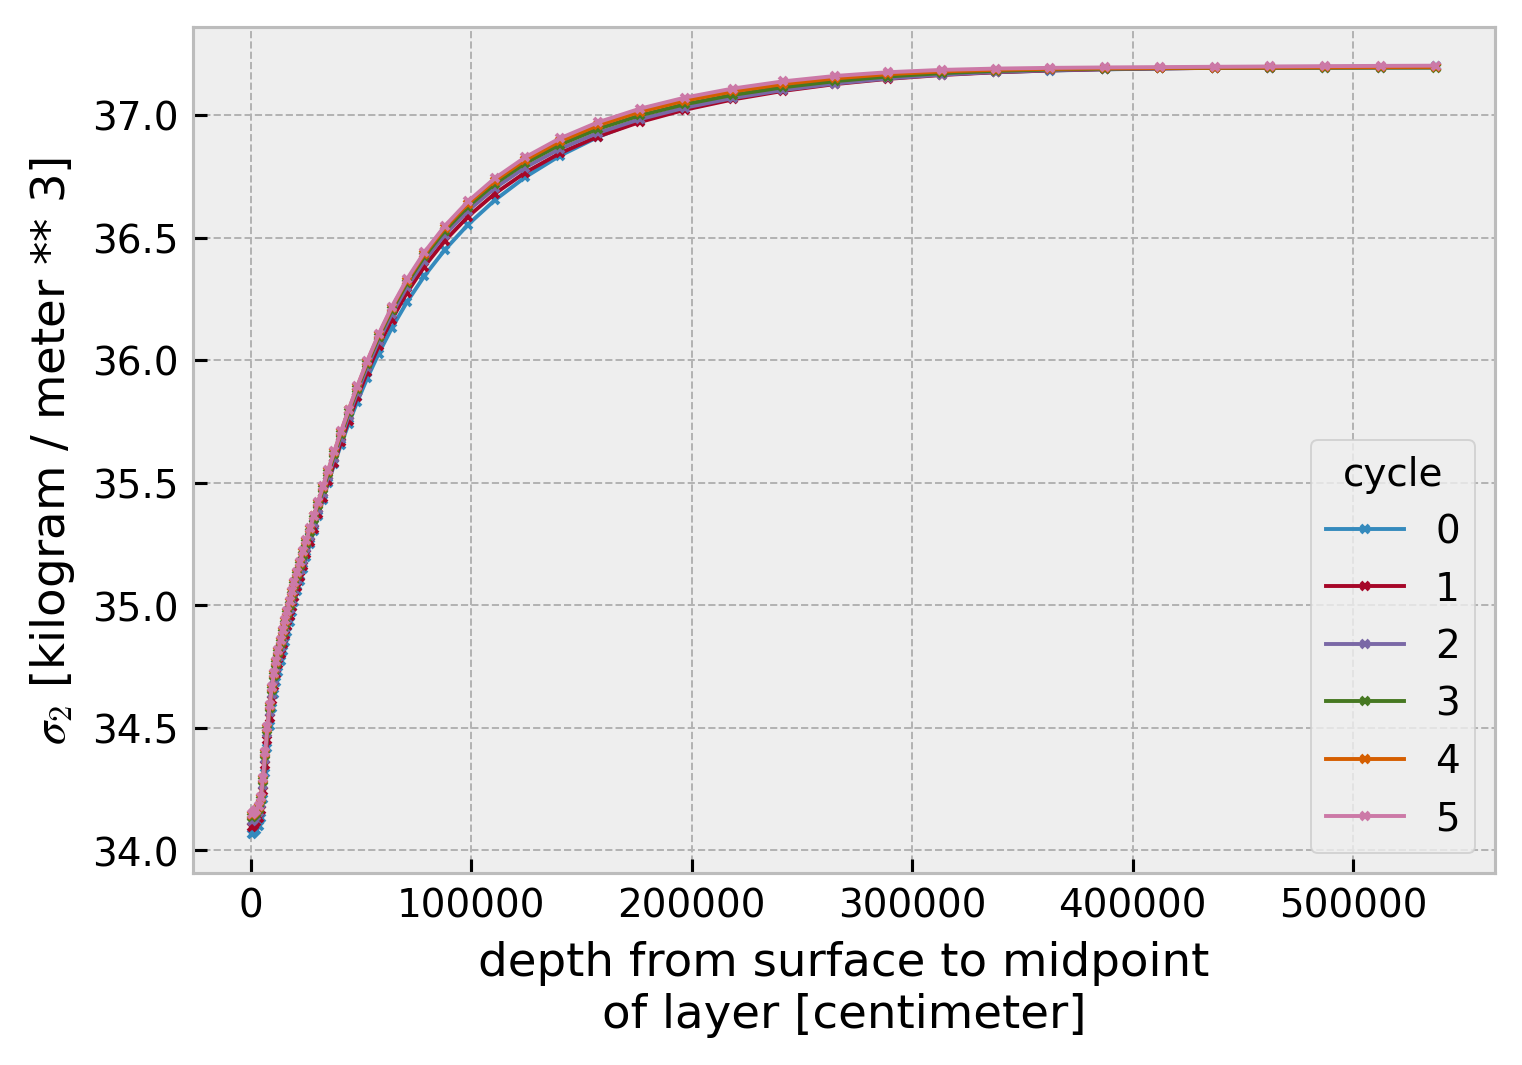

In [23]:
meanrho = xpop1.σ.cf.mean(["T", "Y", "X"]).load()
meanrho.plot(hue="cycle", marker="x", lw=1, ms=2)

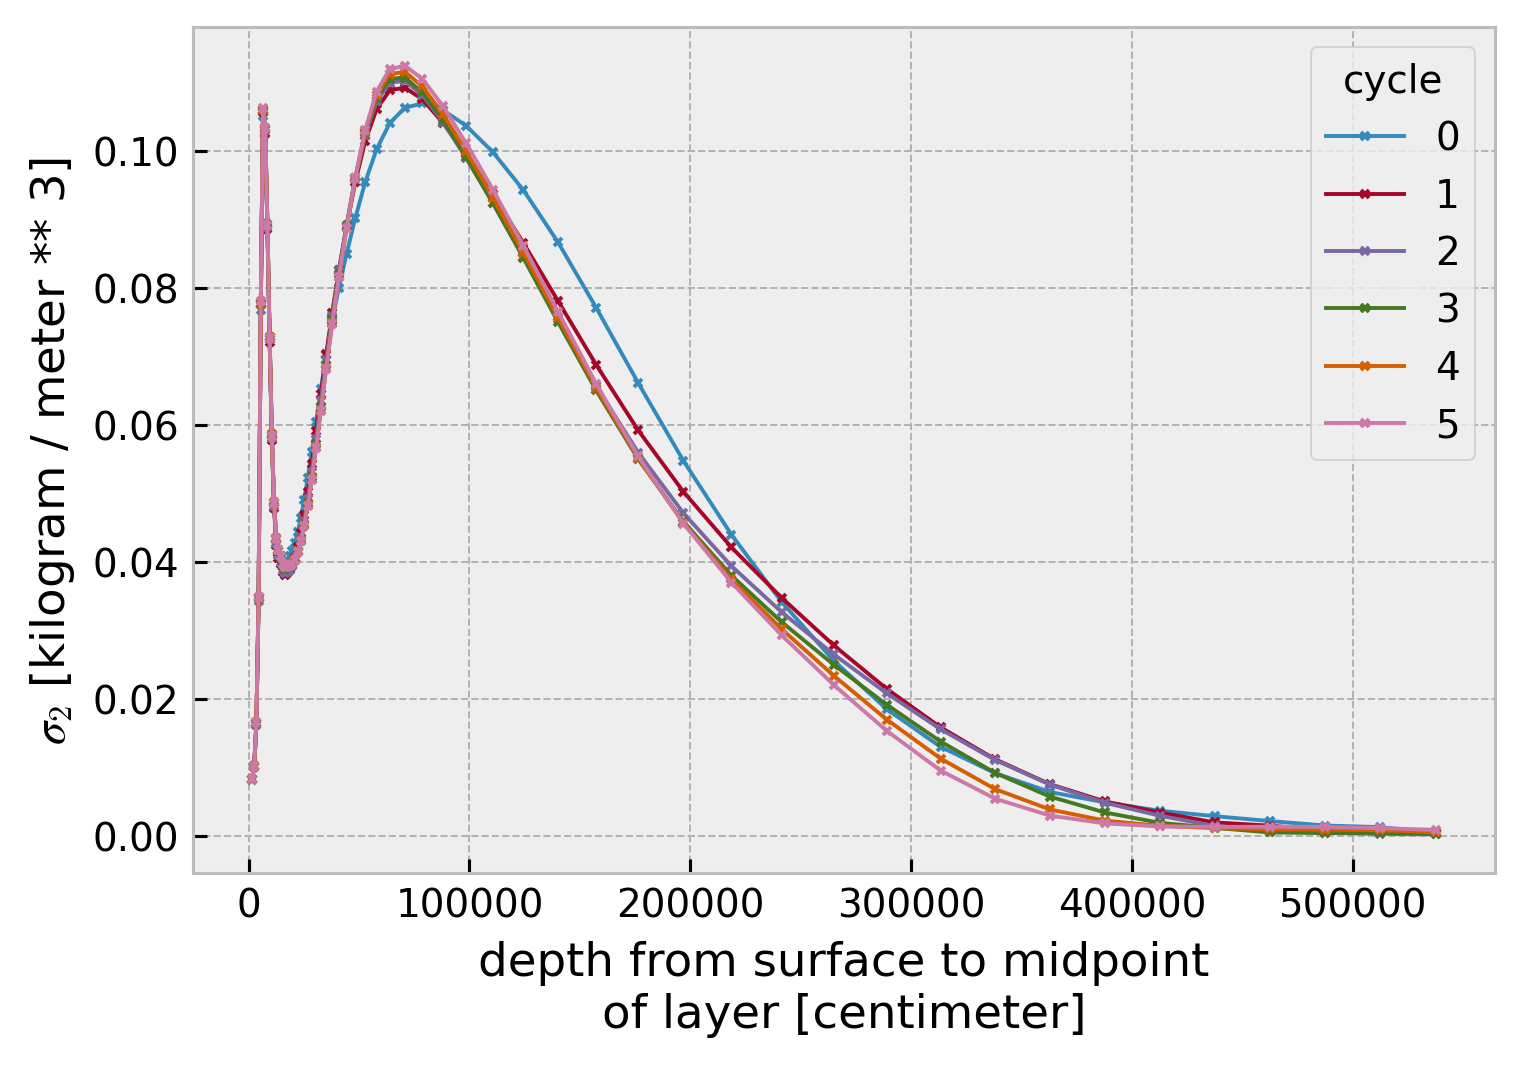

In [24]:
meanrho.cf.diff("Z").plot(marker="x", ms=2, lw=1, hue="cycle")

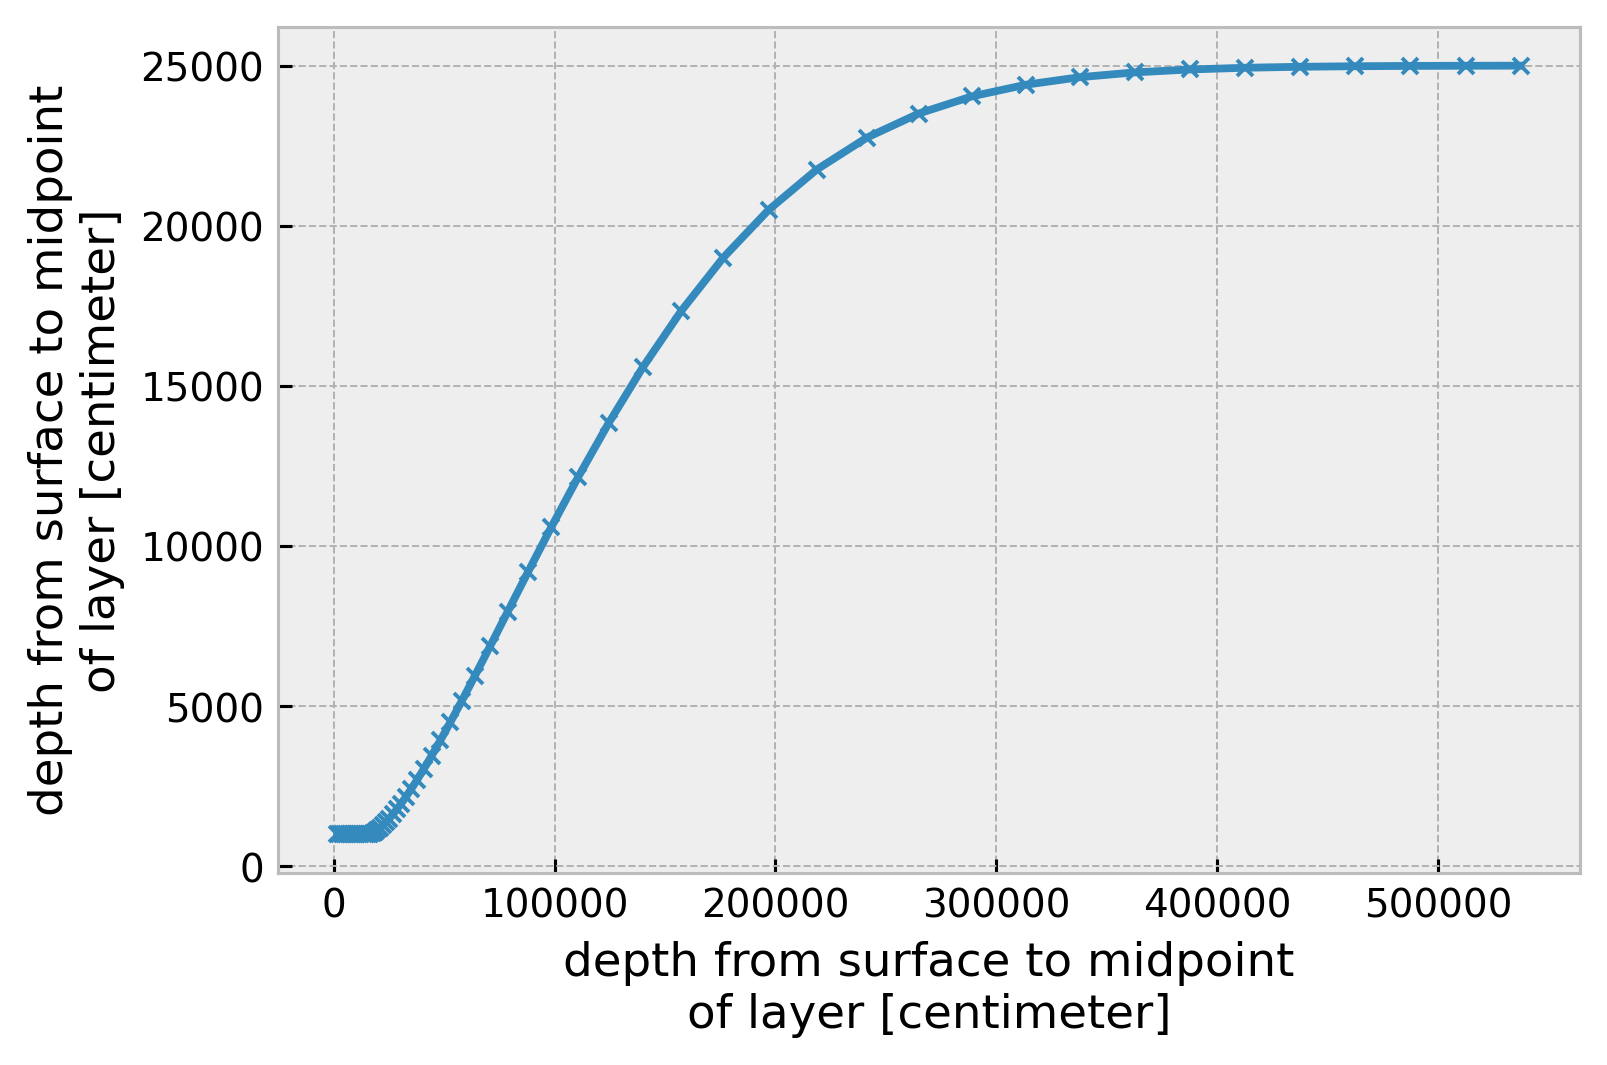

In [25]:
xpop1.z_t.diff("z_t").plot(ms=4, marker="x")

In [29]:
bins = np.round(np.sort(meanrho.isel(cycle=-1).pint.dequantify().data), 3)
bins

array([34.147, 34.155, 34.166, 34.182, 34.217, 34.295, 34.401, 34.504,
       34.594, 34.666, 34.725, 34.773, 34.817, 34.858, 34.899, 34.939,
       34.978, 35.017, 35.056, 35.096, 35.136, 35.178, 35.221, 35.266,
       35.314, 35.366, 35.423, 35.485, 35.553, 35.628, 35.709, 35.798,
       35.894, 35.997, 36.105, 36.217, 36.33 , 36.44 , 36.547, 36.648,
       36.742, 36.828, 36.905, 36.971, 37.026, 37.072, 37.109, 37.138,
       37.16 , 37.175, 37.185, 37.19 , 37.193, 37.195, 37.196, 37.197,
       37.199, 37.2  , 37.201, 37.202], dtype=float32)

### First cycle spinup

In [ ]:
spinup1 = subset_1deg_to_natre(reshaped.isel(cycle=[0]))
grid1, xspinup1 = pop_tools.to_xgcm_grid_dataset(
    spinup1.pint.quantify(),
    **xgcm_kwargs,
)
xspinup1.update(xspinup1.cf[["latitude", "longitude"]].load())
xspinup1["yearmonth"] = spinup1.yearmonth
regridded = estimate_redi_terms(xspinup1, grid1, bins)
regridded

In [6]:
towrite = regridded.reset_index("yearmonth").pint.dequantify().load()
towrite.cf

Coordinates:
- CF Axes: * X: ['nlon_t', 'nlon_u']
           * Y: ['nlat_t', 'nlat_u']
           * Z: ['σ']
             T: ['month', 'year']

- CF Coordinates:   longitude: ['TLONG', 'ULONG']
                    latitude: ['TLAT', 'ULAT']
                    time: ['month', 'year']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In [49]:
(
    set_zarr_compression_encoding(towrite).to_zarr(
        "../datasets/pop-1deg-redi-var-natre-cycle-0.zarr", mode="w"
    )
)

### Years 42-61; all cycles

In [22]:
# select out years 42-61
reshaped_4261 = reshaped.sel(yearmonth=reshaped.year.isin(np.arange(42, 62)))

grid1, xpop1 = pop_tools.to_xgcm_grid_dataset(
    reshaped_4261.pint.quantify(),
    **xgcm_kwargs,
)
xpop1.update(xpop1.cf[["latitude", "longitude"]].load())
xpop1["yearmonth"] = reshaped_4261.yearmonth
xpop1

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_w_top: 60, nlat_t: 384, nlon_t: 320,
                             nlat_u: 384, nlon_u: 320, cycle: 6,
                             yearmonth: 240, d2: 2, z_t_150m: 15, z_w_bot: 60,
                             moc_z: 61)
Coordinates: (12/18)
  * year                    (yearmonth) int64 42 42 42 42 42 ... 61 61 61 61 61
  * month                   (yearmonth) int64 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                      ...
  * cycle                   (cycle) int64 0 1 2 3 4 5
  * yearmonth               (yearmonth) object MultiIndex
  * nlon_u                  (nlon_u) int64 1 2 3 4 5 6 ... 316 317 318 319 320
  * nlat_u                  (nlat_u) int64 1 2 3 4 5 6 ... 380 381 382 383 384
  * nlon_t                  (nlon_t) float64 0.5 1.5 2.5 ... 317.5 318.5 319.5
  * nlat_t                  (nlat_t) float64 0.5 1.5 2.5 ... 381.5 382.5 383.5
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/60)
    moc_components          (moc_comp) |S384 [] dask.array<open_dataset-c54fa...
    transport_components    (transport_comp) |S384 [] dask.array<open_dataset...
    transport_regions       (transport_reg) |S384 [] dask.array<open_dataset-...
    dz                      (z_t) float32 [cm] dask.array<open_dataset-c54fa2...
    dzw                     (z_w_top) float32 [cm] dask.array<open_dataset-c5...
    KMT                     (nlat_t, nlon_t) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...                      ...
    KAPPA_ISOP              (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [cm²/s] dask.array<getitem, shape=(6, 240, 60, 384, 320), dtype=float32, chunksize=(1, 240, 60, 50, 50), chunktype=numpy.n...
    SALT                    (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [g/kg] dask.array<getitem, shape=(6, 240, 60, 384, 320), dtype=float32, chunksize=(1, 240, 60, 50, 50), chunktype=numpy.nd...
    SSH                     (cycle, yearmonth, nlat_t, nlon_t) float32 [cm] d...
    SSH2                    (cycle, yearmonth, nlat_t, nlon_t) float32 [cm²] ...
    TEMP                    (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [°C] dask.array<getitem, shape=(6, 240, 60, 384, 320), dtype=float32, chunksize=(1, 240, 60, 50, 50), chunktype=numpy.ndar...
    σ                       (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [kg/m³] dask.array<getitem, shape=(6, 240, 60, 384, 320), dtype=float32, chunksize=(1, 240, 60, 50, 50), chunktype=numpy.n...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [44]:
regridded1 = ed.pop.regrid_to_density(
    xpop1.sel(cycle=[0]), grid1, bins, ["TEMP", "SALT", "KAPPA_ISOP"]
).squeeze()
regridded1

<xarray.Dataset>
Dimensions:     (yearmonth: 240, nlat_t: 384, nlon_t: 320, σ: 60)
Coordinates:
  * year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  * month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] 320.6 321.7 ... nan nan
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] -79.22 -79.22 ... nan
    time        (yearmonth) object 0042-01-01 00:00:00 ... 0061-12-01 00:00:00
    cycle       int64 0
  * yearmonth   (yearmonth) object MultiIndex
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 316.5 317.5 318.5 319.5
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
  * σ           (σ) float32 34.15 34.15 34.17 34.18 ... 37.2 37.2 37.2 37.2
Data variables:
    z_σ         (yearmonth, nlat_t, nlon_t, σ) float32 [cm] dask.array<getite...
    TEMP        (yearmonth, nlat_t, nlon_t, σ) float32 [°C] dask.array<getite...
    SALT        (yearmonth, nlat_t, nlon_t, σ) float32 [g/kg] dask.array<geti...
    KAPPA_ISOP  (yearmonth, nlat_t, nlon_t, σ) float32 [cm²/s] dask.array<get...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [ ]:
(
    set_zarr_compression_encoding(
        regridded1.pint.dequantify().pipe(cfxr.encode_multi_index_as_compress)
    ).to_zarr("../datasets/pop-1deg-sigma2-grid-0042-0061.zarr", mode="w")
)

### Subset to NATRE

In [21]:
grid1_natre, xpop1_natre = pop_tools.to_xgcm_grid_dataset(
    subset_1deg_to_natre(reshaped_4261).pint.quantify(),
    **xgcm_kwargs,
)
regridded = estimate_redi_terms(xpop1_natre, grid1_natre, bins)
regridded

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning: Metric at ('cycle', 'yearmonth', 'nlat_u', 'nlon_t', 'σ') being interpolated from metrics at dimensions ('nlat_t', 'nlon_t'). Boundary value set to 'extend'.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning: Metric at ('cycle', 'yearmonth', 'nlat_t', 'nlon_u', 'σ') being interpolated from metrics at dimensions ('nlat_t', 'nlon_t'). Boundary value set to 'extend'.
  warnings.warn(


<xarray.Dataset>
Dimensions:     (cycle: 6, yearmonth: 240, nlat_t: 11, nlon_t: 10, σ: 60,
                 nlat_u: 11, nlon_u: 10)
Coordinates: (12/20)
  * year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  * month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] dask.array<getitem, s...
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] dask.array<getitem, ...
    time        (cycle, yearmonth) object 0042-01-01 00:00:00 ... 0366-12-01 ...
  * cycle       (cycle) int64 0 1 2 3 4 5
    ...          ...
    DYU         (nlat_u, nlon_u) float64 [cm] dask.array<getitem, shape=(11, ...
    DYT         (nlat_t, nlon_t) float64 [cm] dask.array<getitem, shape=(11, ...
    ULONG       (nlat_u, nlon_u) float64 [degrees_east] dask.array<getitem, s...
    ULAT        (nlat_u, nlon_u) float64 [degrees_north] dask.array<getitem, ...
  * nlon_u      (nlon_u) int64 1 2 3 4 5 6 7 8 9 10
  * nlat_u      (nlat_u) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    z_σ         (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [cm] dask.array...
    TEMP        (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [°C] dask.array...
    SALT        (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [g/kg] dask.arr...
    KAPPA_ISOP  (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [m²/s] dask.arr...
    delT2       (cycle, yearmonth, nlat_t, nlon_t, σ) float64 dask.array<chunksize=(1, 240, 11, 10, 60), meta=np.ndarray>
    RediVar     (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [cm²/s] dask.ar...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [16]:
towrite = regridded.reset_index("yearmonth").pint.dequantify()  # .load()
towrite.cf

Coordinates:
- CF Axes: * X: ['nlon_t', 'nlon_u']
           * Y: ['nlat_t', 'nlat_u']
           * Z: ['σ']
             T: ['month', 'year']

- CF Coordinates:   longitude: ['TLONG', 'ULONG']
                    latitude: ['TLAT', 'ULAT']
                    time: ['month', 'year']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In [17]:
(
    set_zarr_compression_encoding(towrite).to_zarr(
        "../datasets/pop-1deg-redi-var-natre-0042-0061.zarr", mode="w"
    )
)

### NATRE mean profile

In [243]:
natre = xr.load_dataset(
    "../datasets/pop-1deg-redi-var-natre-0042-0061.zarr", engine="zarr"
).pint.quantify()

There is spiciness

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:635: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return push(array, n, axis)


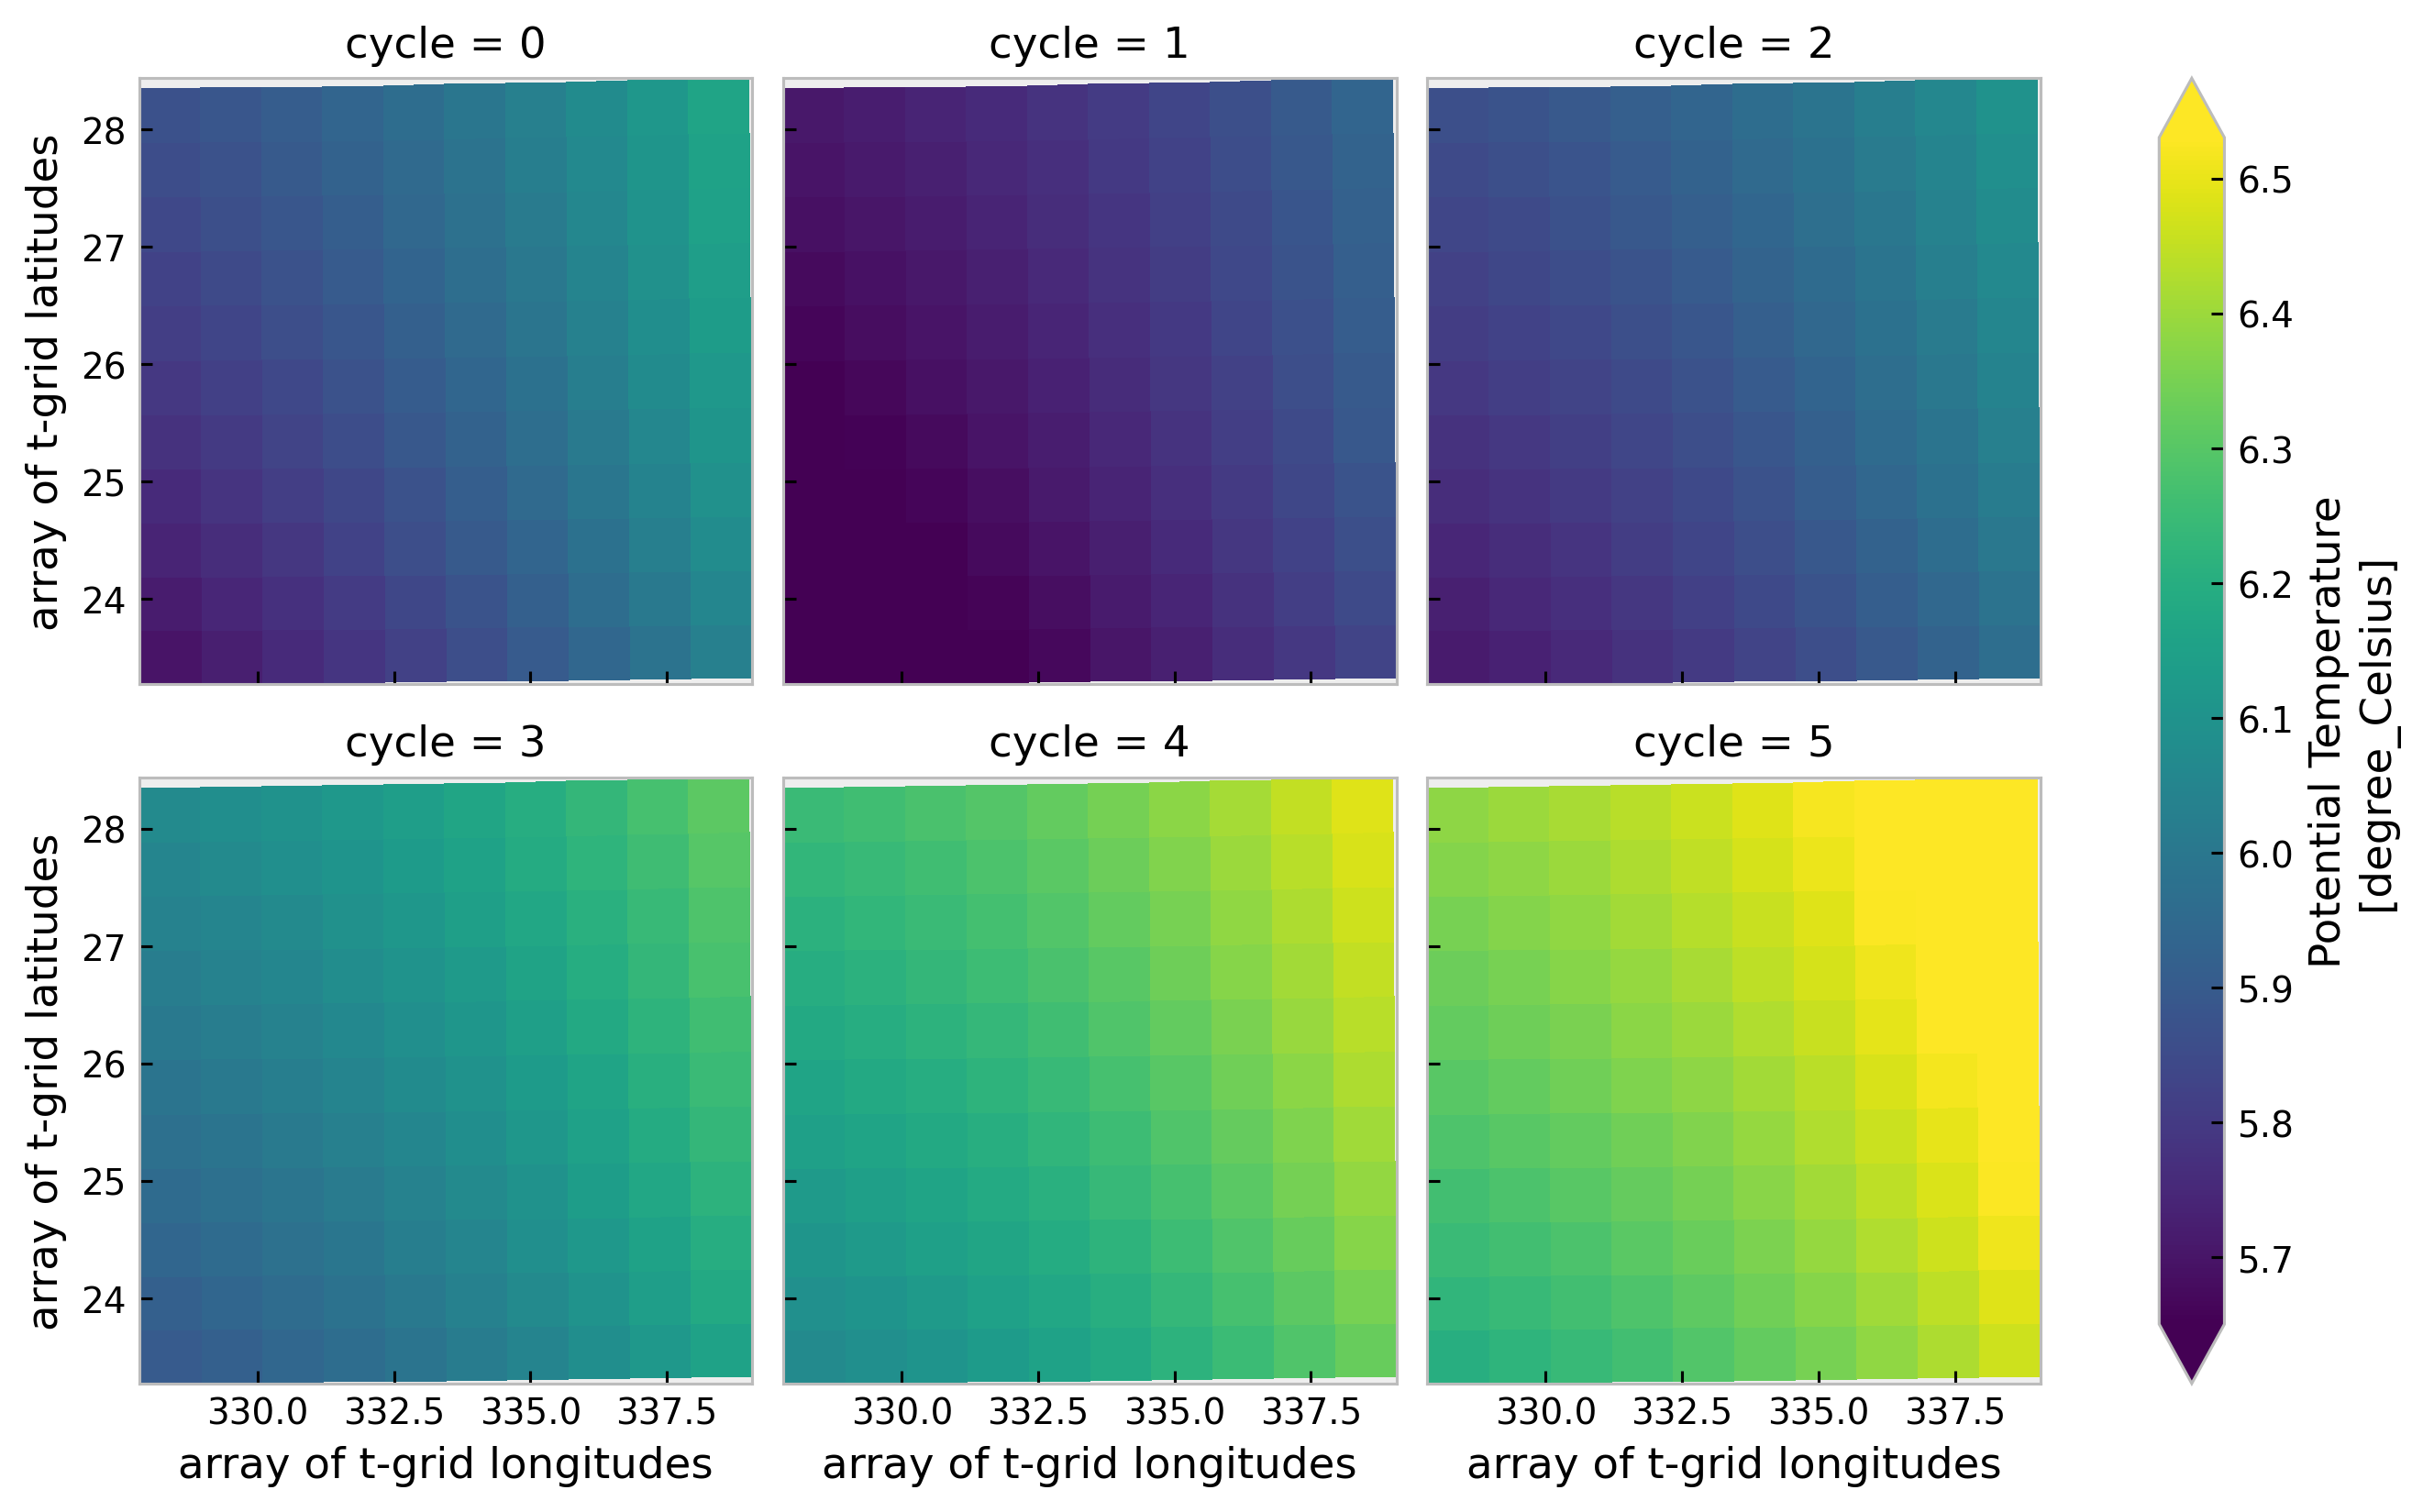

In [169]:
import matplotlib.pyplot as plt

subset = natre.mean("yearmonth").isel(σ=40)
subset["TLAT"] = subset.TLAT.cf.ffill("X")
subset["TLONG"] = subset.TLONG.cf.bfill("Y")
subset.TEMP.plot(x="TLONG", y="TLAT", col="cycle", col_wrap=3, robust=True)

In [247]:
profile = (
    natre.reset_coords("z_σ")
    .cf.mean(["yearmonth", "Y", "X"])
    .load()
    .map(to_base_units)
    .set_coords("z_σ")
)
profile

<xarray.Dataset>
Dimensions:     (cycle: 6, σ: 60)
Coordinates:
  * cycle       (cycle) int64 0 1 2 3 4 5
  * σ           (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
    z_σ         (cycle, σ) float64 [m] 66.9 67.23 67.65 ... 5.036e+03 5.166e+03
Data variables:
    KAPPA_ISOP  (cycle, σ) float64 [m²/s] 2.488e+03 2.486e+03 ... 508.3 464.9
    RediVar     (cycle, σ) float64 [K²/s] 2.956e-09 2.951e-09 ... 8.636e-13
    TEMP        (cycle, σ) float64 [K] 295.8 295.8 295.7 ... 274.8 274.8 274.8
    delT2       (cycle, σ) float64 [K²/m²] 1.157e-12 1.156e-12 ... 1.605e-15
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    time_period_freq:  month_1
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001

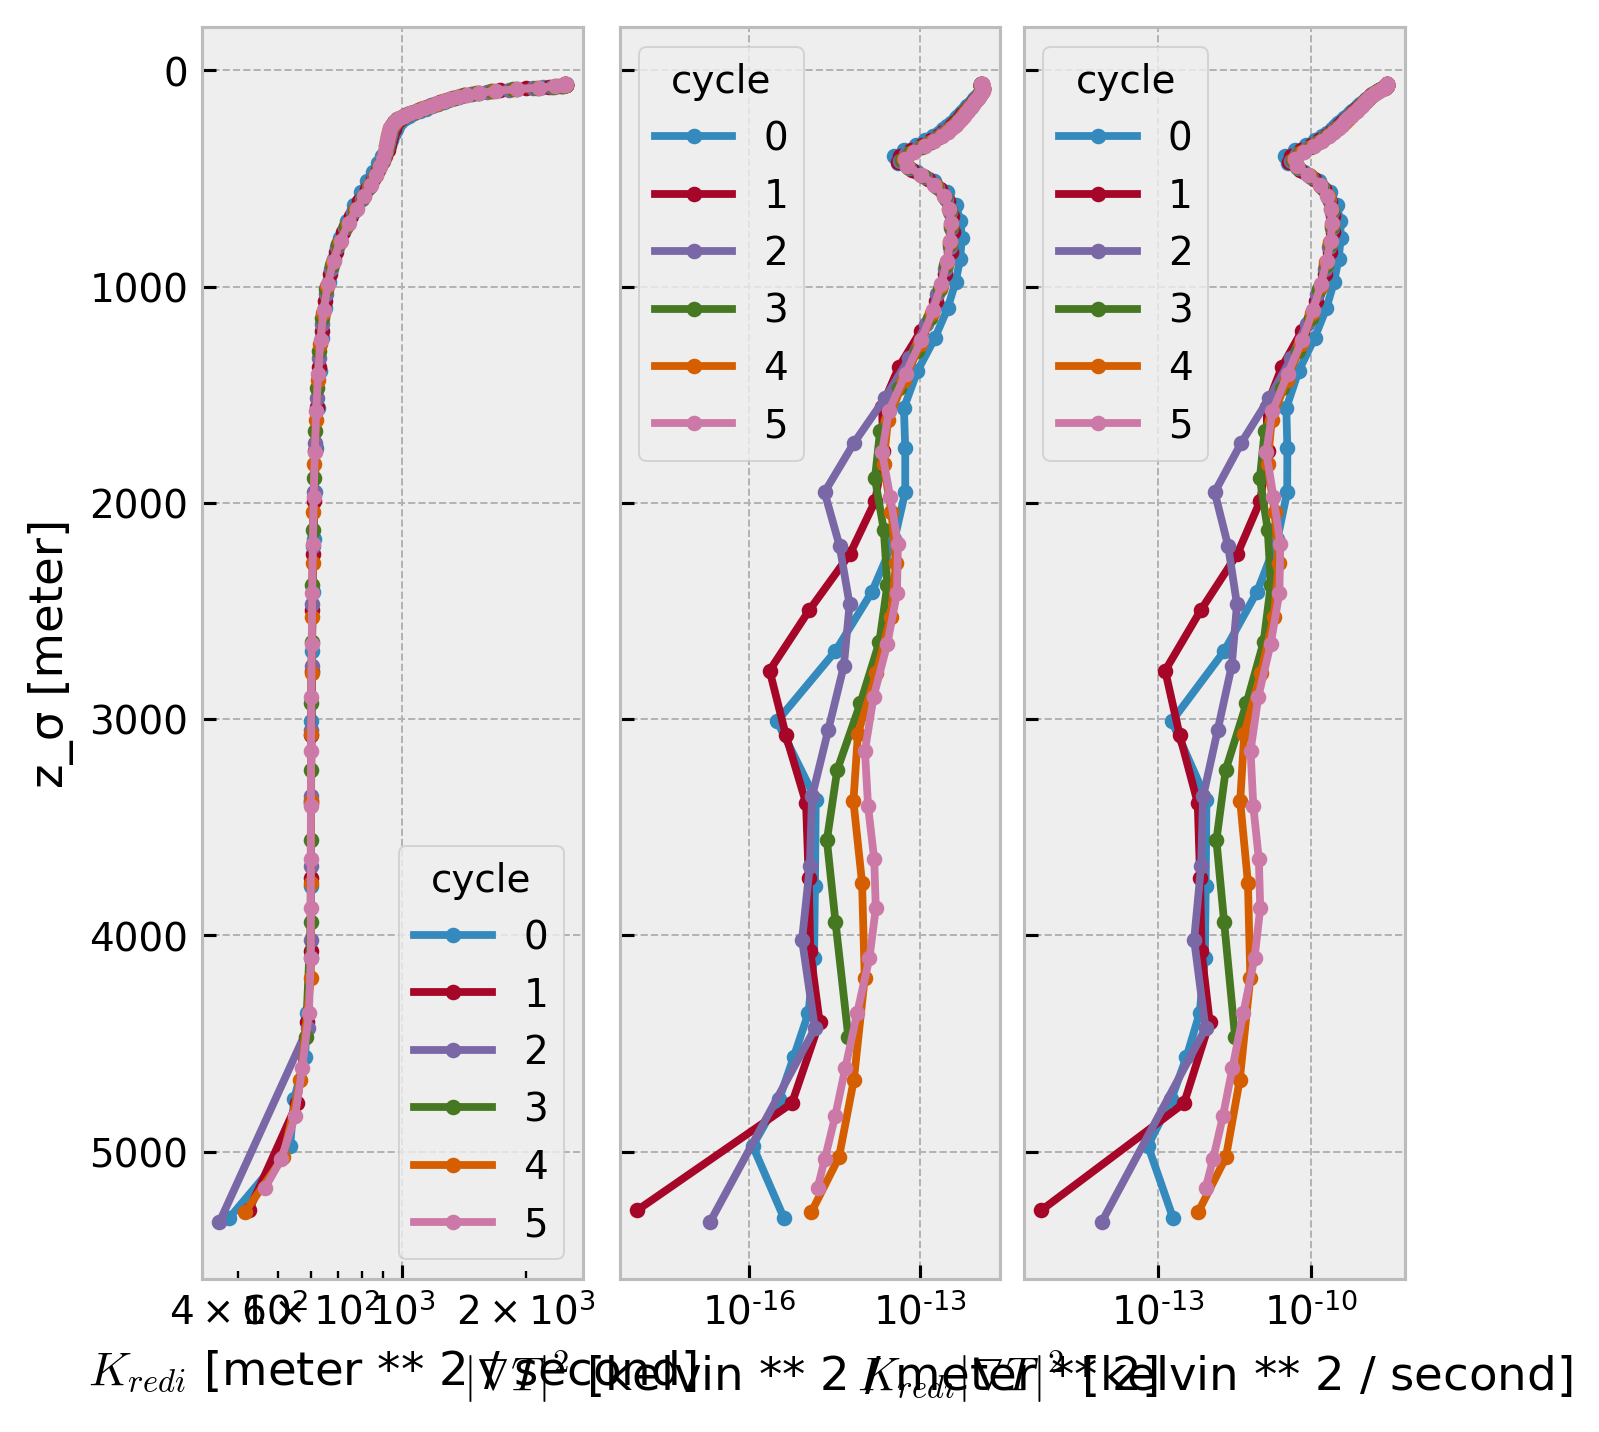

In [248]:
import dcpy

plt.style.use("bmh")
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
profile.KAPPA_ISOP.cf.plot(
    ax=ax[0], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log"
)
profile.delT2.cf.plot(
    ax=ax[1], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log"
)
profile.RediVar.cf.plot(
    ax=ax[2], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log"
)
dcpy.plots.clean_axes(ax)
f.set_size_inches((5, 5))

In [249]:
profile.pint.dequantify().to_netcdf("../datasets/pop-1deg-redivar-natre.nc")

## 1/10° Climatology; no regrid

In [51]:
climdir = "/glade/scratch/bryan/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/tavg"
pop110_ = xr.open_dataset(
    f"{climdir}/g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061.nc",
    chunks={"nlat": 1200, "nlon": 800},
).squeeze()
pop110 = preprocess_pop_dataset(pop110_)
pop110

<xarray.Dataset>
Dimensions:              (z_w_top: 62, z_t: 62, z_w: 62, z_w_bot: 62,
                          z_t_150m: 15, nlat: 2400, nlon: 3600)
Coordinates:
  * z_w_top              (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_t                  (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_w                  (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot              (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_t_150m             (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    time                 object 0052-01-01 05:17:48.750000
    ULONG                (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    TLONG                (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    ULAT                 (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    TLAT                 (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/130)
    latent_heat_fusion   float64 ...
    REGION_MASK          (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    hflux_factor         float64 ...
    HT                   (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    ANGLET               (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    KMU                  (nlat, nlon) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    ...                   ...
    UVEL2                (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
    VDIFFU               (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
    VDIFFV               (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
    VVEL                 (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
    VVEL2                (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
    σ                    (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 1200, 800), meta=np.ndarray>
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [52]:
grid, xpop110 = pop_tools.to_xgcm_grid_dataset(
    pop110.drop("QFLUX").pint.quantify(), periodic=("X", "Y"), metrics=metrics
)
xpop110.update(xpop110.cf[["latitude", "longitude"]].load())
xpop110

<xarray.Dataset>
Dimensions:              (nlat_t: 2400, nlon_t: 3600, nlat_u: 2400,
                          nlon_u: 3600, z_t: 62, z_w_top: 62, z_w_bot: 62,
                          z_t_150m: 15)
Coordinates: (12/13)
  * z_t                  (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_w_top              (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot              (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_t_150m             (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    time                 object 0052-01-01 05:17:48.750000
    ULONG                (nlat_u, nlon_u) float64 [degrees_east] nan nan ... nan
    ...                   ...
    ULAT                 (nlat_u, nlon_u) float64 [degrees_north] nan ... nan
    TLAT                 (nlat_t, nlon_t) float64 [degrees_north] nan ... nan
  * nlon_u               (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u               (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t               (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t               (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Data variables: (12/129)
    latent_heat_fusion   float64 [erg/g] 3.337e+09
    REGION_MASK          (nlat_t, nlon_t) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    hflux_factor         float64 2.439e-05
    HT                   (nlat_t, nlon_t) float64 [cm] dask.array<open_datase...
    ANGLET               (nlat_t, nlon_t) float64 [rad] dask.array<open_datas...
    KMU                  (nlat_u, nlon_u) float64 dask.array<chunksize=(1200, 800), meta=np.ndarray>
    ...                   ...
    UVEL2                (z_t, nlat_u, nlon_u) float32 [cm²/s²] dask.array<ge...
    VDIFFU               (z_t, nlat_u, nlon_u) float32 [cm/s²] dask.array<get...
    VDIFFV               (z_t, nlat_u, nlon_u) float32 [cm/s²] dask.array<get...
    VVEL                 (z_t, nlat_u, nlon_u) float32 [cm/s] dask.array<geti...
    VVEL2                (z_t, nlat_u, nlon_u) float32 [cm²/s²] dask.array<ge...
    σ                    (z_t, nlat_t, nlon_t) float32 [kg/m³] dask.array<sub...
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [53]:
regridded_clim = regrid_to_density(
    xpop110.expand_dims(cycle=1), bins, ["TEMP", "SALT"]
).squeeze()
regridded_clim

<xarray.Dataset>
Dimensions:  (nlat_t: 2400, nlon_t: 3600, σ: 60)
Coordinates:
    time     object 0052-01-01 05:17:48.750000
    TLONG    (nlat_t, nlon_t) float64 [degrees_east] nan nan nan ... nan nan nan
    TLAT     (nlat_t, nlon_t) float64 [degrees_north] nan nan nan ... nan nan
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * σ        (σ) float32 34.15 34.15 34.17 34.18 34.22 ... 37.2 37.2 37.2 37.2
Data variables:
    z_σ      (nlat_t, nlon_t, σ) float32 [cm] dask.array<getitem, shape=(2400...
    TEMP     (nlat_t, nlon_t, σ) float32 [°C] dask.array<getitem, shape=(2400...
    SALT     (nlat_t, nlon_t, σ) float32 [g/kg] dask.array<getitem, shape=(24...
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [121]:
regridded_clim.coords.update(xpop110[pop_metric_vars])
regridded_clim

<xarray.Dataset>
Dimensions:      (nlat_t: 2400, nlon_t: 3600, σ: 60, z_t: 62, z_w_top: 62,
                  nlat_u: 2400, nlon_u: 3600)
Coordinates: (12/31)
    time         object 0052-01-01 05:17:48.750000
    TLONG        (nlat_t, nlon_t) float64 [degrees_east] nan nan nan ... nan nan
    TLAT         (nlat_t, nlon_t) float64 [degrees_north] nan nan ... nan nan
  * nlon_t       (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t       (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.398e+03 2.4e+03
  * σ            (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
    ...           ...
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w_top      (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
    ULONG        (nlat_u, nlon_u) float64 [degrees_east] nan nan nan ... nan nan
    ULAT         (nlat_u, nlon_u) float64 [degrees_north] nan nan ... nan nan
  * nlon_u       (nlon_u) int64 1 2 3 4 5 6 7 ... 3595 3596 3597 3598 3599 3600
  * nlat_u       (nlat_u) int64 1 2 3 4 5 6 7 ... 2395 2396 2397 2398 2399 2400
Data variables:
    z_σ          (nlat_t, nlon_t, σ) float32 [cm] dask.array<getitem, shape=(...
    TEMP         (nlat_t, nlon_t, σ) float32 [°C] dask.array<getitem, shape=(...
    SALT         (nlat_t, nlon_t, σ) float32 [g/kg] dask.array<getitem, shape...
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [41]:
(
    regridded_clim.load()
    .pint.dequantify()
    .to_netcdf("../datasets/pop-hires-annual-climatology.nc")
)

## 1/10° regrid; then density space

### Regrid 1/10° to 1°

In [54]:
climdir = "/glade/scratch/bryan/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/tavg"
pop110_ = xr.open_dataset(
    f"{climdir}/g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061.nc",
    chunks={"z_t": 10},
).squeeze()
pop110 = preprocess_pop_dataset(pop110_)
pop110

<xarray.Dataset>
Dimensions:              (z_w_top: 62, z_t: 62, z_w: 62, z_w_bot: 62,
                          z_t_150m: 15, nlat: 2400, nlon: 3600)
Coordinates:
  * z_w_top              (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_t                  (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_w                  (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot              (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_t_150m             (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    time                 object 0052-01-01 05:17:48.750000
    ULONG                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/130)
    latent_heat_fusion   float64 ...
    REGION_MASK          (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    hflux_factor         float64 ...
    HT                   (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                   ...
    UVEL2                (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    VDIFFU               (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    VDIFFV               (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    VVEL                 (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    VVEL2                (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    σ                    (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [55]:
cluster.scale(8)

In [59]:
grid110, xpop110 = pop_tools.to_xgcm_grid_dataset(
    pop110.drop("QFLUX").pint.quantify(), periodic=("X", "Y"), metrics=metrics
)
xpop110.update(xpop110.cf[["latitude", "longitude"]].load())
xpop110

<xarray.Dataset>
Dimensions:              (nlat_t: 2400, nlon_t: 3600, nlat_u: 2400,
                          nlon_u: 3600, z_t: 62, z_w_top: 62, z_w_bot: 62,
                          z_t_150m: 15)
Coordinates: (12/13)
  * z_t                  (z_t) float64 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_w_top              (z_w_top) float64 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot              (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_t_150m             (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    time                 object 0052-01-01 05:17:48.750000
    ULONG                (nlat_u, nlon_u) float64 [degrees_east] -109.9 ... -...
    ...                   ...
    ULAT                 (nlat_u, nlon_u) float64 [degrees_north] -78.45 ... ...
    TLAT                 (nlat_t, nlon_t) float64 [degrees_north] -78.47 ... ...
  * nlon_u               (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u               (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t               (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t               (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Data variables: (12/129)
    latent_heat_fusion   float64 [erg/g] 3.337e+09
    REGION_MASK          (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    hflux_factor         float64 2.439e-05
    HT                   (nlat_t, nlon_t) float64 [cm] dask.array<open_datase...
    ANGLET               (nlat_t, nlon_t) float64 [rad] dask.array<open_datas...
    KMU                  (nlat_u, nlon_u) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                   ...
    UVEL2                (z_t, nlat_u, nlon_u) float32 [cm²/s²] dask.array<ge...
    VDIFFU               (z_t, nlat_u, nlon_u) float32 [cm/s²] dask.array<get...
    VDIFFV               (z_t, nlat_u, nlon_u) float32 [cm/s²] dask.array<get...
    VVEL                 (z_t, nlat_u, nlon_u) float32 [cm/s] dask.array<geti...
    VVEL2                (z_t, nlat_u, nlon_u) float32 [cm²/s²] dask.array<ge...
    σ                    (z_t, nlat_t, nlon_t) float32 [kg/m³] dask.array<sub...
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [60]:
import regrid

source = pop_tools.get_grid("POP_tx0.1v3").set_coords(
    ["ULAT", "ULONG", "TLAT", "TLONG"]
)
dest = pop_tools.get_grid("POP_gx1v7").set_coords(["ULAT", "ULONG", "TLAT", "TLONG"])

# TODO : select out vars at TLONG, TLAT
dst_grid = regrid._prep_for_xesmf(dest, "POP_gx1v7").coords.to_dataset()
pop110.update(source.coords)
coarsened_ = regrid._regrid_dataset(pop110[["TEMP", "SALT", "σ"]], dst_grid)
for var in coarsened_:
    coarsened_[var].attrs = pop110[var].attrs

coarsened_.coords.update(dest[pop_metric_vars])
coarsened_

<xarray.Dataset>
Dimensions:  (z_t: 62, nlat: 384, nlon: 320)
Coordinates: (12/14)
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    time     object 0052-01-01 05:17:48.750000
    lon      (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lat      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    UAREA    (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.638e+12 7.639e+12
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    ...       ...
    DYU      (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    DYT      (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 384, 320), meta=np.ndarray>
    SALT     (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 384, 320), meta=np.ndarray>
    σ        (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

### To density space

In [64]:
gridcoarse, coarsened = pop_tools.to_xgcm_grid_dataset(
    coarsened_.pint.quantify(), metrics=metrics, periodic=("X", "Y")
)
coarsened.load()

<xarray.Dataset>
Dimensions:  (z_t: 62, nlat_t: 384, nlon_t: 320, nlat: 384, nlon: 320,
              nlat_u: 384, nlon_u: 320)
Coordinates: (12/18)
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    time     object 0052-01-01 05:17:48.750000
    lon      (nlat, nlon) float64 [degrees_east] 320.6 321.7 ... 319.4 319.8
    lat      (nlat, nlon) float64 [degrees_north] -79.22 -79.22 ... 72.19 72.19
    UAREA    (nlat_u, nlon_u) float64 [cm²] 1.423e+13 1.423e+13 ... 7.639e+12
    TAREA    (nlat_t, nlon_t) float64 [cm²] 1.125e+13 1.125e+13 ... 7.432e+12
    ...       ...
    ULAT     (nlat_u, nlon_u) float64 [degrees_north] -78.95 -78.95 ... 72.41
    ULONG    (nlat_u, nlon_u) float64 [degrees_east] 321.1 322.3 ... 319.6 320.0
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 316.5 317.5 318.5 319.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat_t, nlon_t) float32 [°C] nan nan nan nan ... nan nan nan
    SALT     (z_t, nlat_t, nlon_t) float32 [g/kg] nan nan nan ... nan nan nan
    σ        (z_t, nlat_t, nlon_t) float64 [kg/m³] nan nan nan ... nan nan nan
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [69]:
regridded_coarsened_clim = estimate_redi_terms(
    coarsened.expand_dims(cycle=1), gridcoarse, bins
)
regridded_coarsened_clim

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning: Metric at ('cycle', 'nlat_u', 'nlon_t', 'σ') being interpolated from metrics at dimensions ('nlat_t', 'nlon_t'). Boundary value set to 'extend'.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning:

<xarray.Dataset>
Dimensions:  (cycle: 1, nlat_t: 384, nlon_t: 320, σ: 60, nlat_u: 384,
              nlon_u: 320)
Coordinates: (12/16)
    time     object 0052-01-01 05:17:48.750000
    TAREA    (nlat_t, nlon_t) float64 [cm²] 1.125e+13 1.125e+13 ... 7.432e+12
    DXT      (nlat_t, nlon_t) float64 [cm] 1.894e+06 1.893e+06 ... 1.473e+06
    DYT      (nlat_t, nlon_t) float64 [cm] 5.94e+06 5.94e+06 ... 5.046e+06
    TLAT     (nlat_t, nlon_t) float64 [degrees_north] -79.22 -79.22 ... 72.19
    TLONG    (nlat_t, nlon_t) float64 [degrees_east] 320.6 321.7 ... 319.4 319.8
    ...       ...
    DXU      (nlat_u, nlon_u) float64 [cm] 2.397e+06 2.397e+06 ... 1.391e+06
    DYU      (nlat_u, nlon_u) float64 [cm] 5.94e+06 5.94e+06 ... 5.493e+06
    ULAT     (nlat_u, nlon_u) float64 [degrees_north] -78.95 -78.95 ... 72.41
    ULONG    (nlat_u, nlon_u) float64 [degrees_east] 321.1 322.3 ... 319.6 320.0
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
Dimensions without coordinates: cycle
Data variables:
    z_σ      (cycle, nlat_t, nlon_t, σ) float64 [cm] nan nan nan ... nan nan nan
    TEMP     (cycle, nlat_t, nlon_t, σ) float64 [°C] nan nan nan ... nan nan nan
    SALT     (cycle, nlat_t, nlon_t, σ) float64 [g/kg] nan nan nan ... nan nan
    delT2    (cycle, nlat_t, nlon_t, σ) float64 [Δ°C²/cm²] nan nan ... nan nan
Attributes: (12/14)
    history:                    Mon Apr 15 11:06:38 2019: ncks -A 1st_half/ta...
    title:                      g.e20.G.TL319_t13.control.001_hfreq
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           day_5
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    yrs_averaged:               42-61
    ...                         ...
    calendar:                   All years have exactly  365 days.
    start_time:                 This dataset was created on 2019-01-16 at 20:...
    contents:                   Diagnostic and Prognostic Variables
    revision:                   $Id: tavg.F90 89091 2018-04-30 15:58:32Z altu...
    history_of_appended_files:  Mon Apr 15 11:06:38 2019: Appended file 1st_h...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...

In [70]:
(
    regridded_coarsened_clim.load()
    .pipe(subset_1deg_to_natre)
    .pint.dequantify()
    .to_netcdf("../datasets/pop-hires-natre-coarsened-annual-climatology.nc")
)